Import libraries

In [47]:
import astropy.io.fits as pyfits

import os
import numpy as np
#from scipy.misc import imresize
from skimage.transform import resize
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
from keras.models import Model
from keras.layers import Input, Conv2D, Activation, Flatten, Dense, AveragePooling2D, MaxPooling2D
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator

Load labels file, create labels based on threshold

In [3]:
label_file = "R_filtrid/BD_decomp_asi.txt"
threshold = 1.5
galaxies_info = pd.read_table(label_file, sep='\t', lineterminator='\n',skiprows=1,header=None,index_col=False,
                              names=["cnr","n","kval","varb","dust","popul","rescale"],
                             usecols=["cnr","kval","varb","dust","popul","rescale"])
galaxies_info['LABEL'] =  np.array(galaxies_info['kval']>threshold).astype(int)
galaxies_info.head(10)

,cnr,kval,varb,dust,popul,rescale,LABEL
0,105,2.0,0,T,T,F,1
1,106,1.0,1,F,F,F,0
2,107,2.0,0.2,F,T,F,1
3,108,1.5,0,F,T,F,0
4,113,2.0,0,F,T,F,1
5,114,1.5,0.2,F,T,F,0
6,115,2.0,0,F,F,T,1
7,116,1.7,0,T,T,T,1
8,117,1.8,0,F,T,F,1
9,118,2.0,0,T,T,F,1


In [4]:
labels = np.array(galaxies_info['LABEL'])

Load fits data. If log_transform is True, apply logarithm scaling (as in SAO Image)

In [14]:
galaxies_fits = []
#max_shape0 = 0
#max_shape1 = 0
im_size = 128
path = "R_filtrid/"
a=1000
log_transform = True
#min_val = 0
#max_val = 0
for num in galaxies_info['cnr']:
    fits_file = pyfits.getdata(path+str(num)+".fits")
    #if fits_file.min()<min_val:
    #    min_val = fits_file.min()
    #if fits_file.max()>max_val:
    #    max_val = fits_file.max()
    if log_transform:
        fits_file = np.log(a*(fits_file-fits_file.min())/(fits_file.max()-fits_file.min())+1)/np.log(a)
    compressed_file = resize(fits_file,(im_size,im_size),mode='constant',cval=0,preserve_range=True)
    galaxies_fits.append(compressed_file)
    #if compressed_file.shape[0]>max_shape0:
    #    max_shape0=compressed_file.shape[0]
    #if compressed_file.shape[1]>max_shape1:
    #    max_shape1=compressed_file.shape[1]

Try out some images

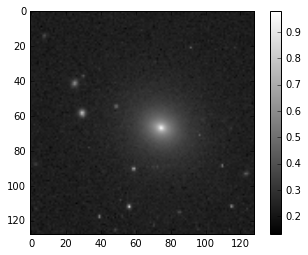

In [41]:
plt.imshow(galaxies_fits[99], cmap='gray')
plt.colorbar()

Add extra dimension (NxM -> NxMx1) for the correct work of NN

In [23]:
galaxies = []
for arr in galaxies_fits:
    #padded_arr = np.pad(arr,((im_size-arr.shape[0], 0), (im_size-arr.shape[1], 0)), 'constant')
    galaxies.append(arr[:, :, np.newaxis])

In [24]:
galaxies.shape

(128, 128, 1)

In [27]:
galaxies_array = np.array(galaxies)
galaxies_array.min(),galaxies_array.max()

(0.0050296873159883602, 0.99960371871929987)

Make a train/test data split

In [113]:
X_train, X_test, y_train, y_test = train_test_split(galaxies_array, labels, test_size=0.2, random_state=2)

Define the model architecture

In [114]:
# We first need to define the sequence of dependencies (the computational graph)
x = Input(shape=(im_size, im_size, 1))
h = Conv2D(96, (8, 8))(x)
h = Activation('relu')(h)
h = MaxPooling2D(pool_size = (3, 3))(h)
h = Flatten()(h)
h = Dense(24)(h)
h = Activation('relu')(h)
h = Dense(1)(h)
p = Activation('softmax')(h)

# Now that we have defined how to find p from x, we can create a 
# model simply by saying what is input and what is output
model = Model(inputs=x, outputs=p)
model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.00001), metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         (None, 128, 128, 1)       0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 121, 121, 96)      6240      
_________________________________________________________________
activation_25 (Activation)   (None, 121, 121, 96)      0         
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 40, 40, 96)        0         
_________________________________________________________________
flatten_9 (Flatten)          (None, 153600)            0         
_________________________________________________________________
dense_17 (Dense)             (None, 24)                3686424   
_________________________________________________________________
activation_26 (Activation)   (None, 24)                0         
__________

Fit and evaluate the model

In [115]:
history = model.fit(X_train, y_train,
          epochs=30,
          validation_split=0.2)

Train on 456 samples, validate on 115 samples
Epoch 1/30
456/456 [==============================] - 31s 68ms/step - loss: 12.8308 - acc: 0.1952 - val_loss: 13.1698 - val_acc: 0.1739
Epoch 2/30
456/456 [==============================] - 31s 69ms/step - loss: 12.8308 - acc: 0.1952 - val_loss: 13.1698 - val_acc: 0.1739
Epoch 3/30
456/456 [==============================] - 30s 66ms/step - loss: 12.8308 - acc: 0.1952 - val_loss: 13.1698 - val_acc: 0.1739
Epoch 4/30
456/456 [==============================] - 31s 67ms/step - loss: 12.8308 - acc: 0.1952 - val_loss: 13.1698 - val_acc: 0.1739
Epoch 5/30
456/456 [==============================] - 31s 67ms/step - loss: 12.8308 - acc: 0.1952 - val_loss: 13.1698 - val_acc: 0.1739
Epoch 6/30
456/456 [==============================] - 30s 65ms/step - loss: 12.8308 - acc: 0.1952 - val_loss: 13.1698 - val_acc: 0.1739
Epoch 7/30
456/456 [==============================] - 31s 68ms/step - loss: 12.8308 - acc: 0.1952 - val_loss: 13.1698 - val_acc: 0.1739
Ep

KeyboardInterrupt: 

In [63]:
def Model_evaluate(model,X_test,y_test,batch_size,history):
    '''
    A function for printing out accuracy, confusion matrix and training plots
    '''
    y_prob = model.predict(X_test,batch_size=batch_size)
    y_pred = y_prob.argmax(axis=-1)
    print("Test accuracy",accuracy_score(y_test,y_pred))
    cm = confusion_matrix(y_test, y_pred)
    print("Confusion matrix")
    print(cm)
    
    # summarize history for accuracy
    plt.figure()
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    
    # summarize history for loss
    plt.figure()
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')

Test accuracy 0.804195804196
Confusion matrix
[[115   0]
 [ 28   0]]


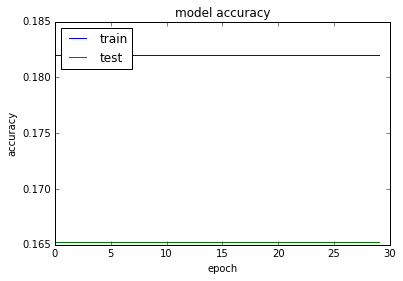

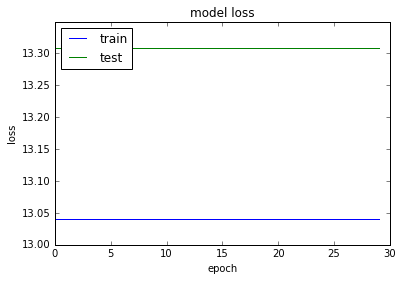

In [101]:
Model_evaluate(model,X_test,y_test,batch_size,history)

## Lets try class weights

In [120]:
#Re-init the model
model = Model(inputs=x, outputs=p)
model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.00001), metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         (None, 128, 128, 1)       0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 121, 121, 96)      6240      
_________________________________________________________________
activation_25 (Activation)   (None, 121, 121, 96)      0         
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 40, 40, 96)        0         
_________________________________________________________________
flatten_9 (Flatten)          (None, 153600)            0         
_________________________________________________________________
dense_17 (Dense)             (None, 24)                3686424   
_________________________________________________________________
activation_26 (Activation)   (None, 24)                0         
__________

In [123]:
class_weight = {0 : 1., 1: len(labels)/sum(labels)}
print(class_weight)

{0: 1.0, 1: 5.4923076923076923}


In [124]:
history = model.fit(X_train, y_train,
          epochs=30,
          batch_size=batch_size,
          validation_split=0.2,
          class_weight = class_weight)

Train on 387 samples, validate on 97 samples
Epoch 1/30
387/387 [==============================] - 26s 66ms/step - loss: 12.8940 - acc: 0.1912 - val_loss: 13.9701 - val_acc: 0.1237
Epoch 2/30
387/387 [==============================] - 26s 67ms/step - loss: 12.8940 - acc: 0.1912 - val_loss: 13.9701 - val_acc: 0.1237
Epoch 3/30
387/387 [==============================] - 28s 71ms/step - loss: 12.8940 - acc: 0.1912 - val_loss: 13.9701 - val_acc: 0.1237
Epoch 4/30
387/387 [==============================] - 26s 66ms/step - loss: 12.8940 - acc: 0.1912 - val_loss: 13.9701 - val_acc: 0.1237
Epoch 5/30
387/387 [==============================] - 25s 64ms/step - loss: 12.8940 - acc: 0.1912 - val_loss: 13.9701 - val_acc: 0.1237
Epoch 6/30
387/387 [==============================] - 26s 68ms/step - loss: 12.8940 - acc: 0.1912 - val_loss: 13.9701 - val_acc: 0.1237
Epoch 7/30
387/387 [==============================] - 26s 68ms/step - loss: 12.8940 - acc: 0.1912 - val_loss: 13.9701 - val_acc: 0.1237
Epo

Test accuracy 0.804195804196
Confusion matrix
[[115   0]
 [ 28   0]]


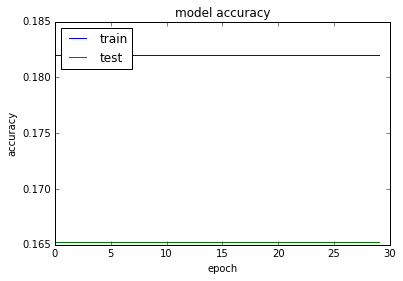

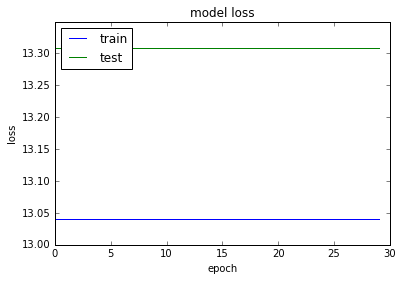

In [105]:
Model_evaluate(model,X_test,y_test,batch_size,history)

## Lets try data augmentation

In [77]:
#Re-init the model
model = Model(inputs=x, outputs=p)
model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(lr=0.00001), metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 128, 128, 1)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 121, 121, 96)      6240      
_________________________________________________________________
activation_10 (Activation)   (None, 121, 121, 96)      0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 40, 40, 96)        0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 153600)            0         
_________________________________________________________________
dense_7 (Dense)              (None, 24)                3686424   
_________________________________________________________________
activation_11 (Activation)   (None, 24)                0         
__________

Define augmentation rules

In [78]:
datagen_train = ImageDataGenerator(
    featurewise_center = False,
    samplewise_center = False,
    featurewise_std_normalization = False,
    samplewise_std_normalization = False,
    rotation_range=20,
    width_shift_range=0.5,
    height_shift_range=0.5,
    zoom_range = 0.5,
    fill_mode = 'constant',
    vertical_flip = True,
    horizontal_flip=True)
datagen_test = datagen_train

Make train/validation/test split

In [119]:
X_train, X_test, y_train, y_test = train_test_split(galaxies_array, labels, test_size=0.15, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=1)

In [80]:
datagen_train.fit(X_train)
datagen_test.fit(X_test)

Train the model on augmented data

In [81]:
history = model.fit_generator(datagen_train.flow(X_train, y_train, batch_size = batch_size),
                    steps_per_epoch = len(X_train)/batch_size, epochs = 30,
                    validation_data = datagen_test.flow(X_val, y_val, batch_size = batch_size),
                    validation_steps = len(X_val)/batch_size)

Epoch 1/30
16/15 [===============================] - 34s 2s/step - loss: 0.5787 - acc: 0.8057 - val_loss: 0.5062 - val_acc: 0.8361
Epoch 2/30
16/15 [===============================] - 33s 2s/step - loss: 0.5350 - acc: 0.8315 - val_loss: 0.4892 - val_acc: 0.8279
Epoch 3/30
16/15 [===============================] - 33s 2s/step - loss: 0.5416 - acc: 0.8186 - val_loss: 0.4711 - val_acc: 0.8361
Epoch 4/30
16/15 [===============================] - 33s 2s/step - loss: 0.5557 - acc: 0.8057 - val_loss: 0.4550 - val_acc: 0.8525
Epoch 5/30
16/15 [===============================] - 32s 2s/step - loss: 0.5196 - acc: 0.8186 - val_loss: 0.5359 - val_acc: 0.7787
Epoch 6/30
16/15 [===============================] - 31s 2s/step - loss: 0.5171 - acc: 0.8186 - val_loss: 0.5105 - val_acc: 0.8033
Epoch 7/30
16/15 [===============================] - 33s 2s/step - loss: 0.5195 - acc: 0.8186 - val_loss: 0.5236 - val_acc: 0.7787
Epoch 8/30
16/15 [===============================] - 33s 2s/step - loss: 0.5021 - a

Test accuracy 0.796296296296
Confusion matrix
[[86  0]
 [22  0]]


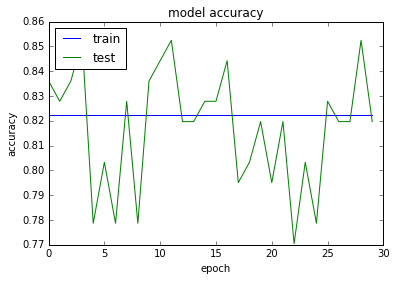

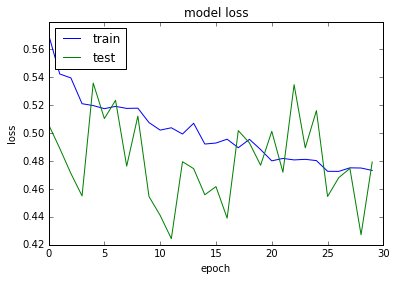

In [82]:
Model_evaluate(model,X_test,y_test,batch_size,history)

## Lets try augmentation and class weights

In [83]:
#Re-init the model
model = Model(inputs=x, outputs=p)
model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(lr=0.00001), metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 128, 128, 1)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 121, 121, 96)      6240      
_________________________________________________________________
activation_10 (Activation)   (None, 121, 121, 96)      0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 40, 40, 96)        0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 153600)            0         
_________________________________________________________________
dense_7 (Dense)              (None, 24)                3686424   
_________________________________________________________________
activation_11 (Activation)   (None, 24)                0         
__________

In [84]:
class_weight = {0 : 1., 1: len(labels)/sum(labels)}
history = model.fit_generator(datagen_train.flow(X_train, y_train, batch_size = batch_size),
                    steps_per_epoch = len(X_train)/batch_size, epochs = 30,
                    validation_data = datagen_test.flow(X_val, y_val, batch_size = batch_size),
                    validation_steps = len(X_val)/batch_size,
                    class_weight = class_weight)

Epoch 1/30
16/15 [===============================] - 33s 2s/step - loss: 1.6225 - acc: 0.8186 - val_loss: 0.5401 - val_acc: 0.7951
Epoch 2/30
16/15 [===============================] - 33s 2s/step - loss: 1.3417 - acc: 0.8315 - val_loss: 0.5444 - val_acc: 0.8197
Epoch 3/30
16/15 [===============================] - 34s 2s/step - loss: 1.4963 - acc: 0.7929 - val_loss: 0.5544 - val_acc: 0.8361
Epoch 4/30
16/15 [===============================] - 31s 2s/step - loss: 1.3636 - acc: 0.8186 - val_loss: 0.5666 - val_acc: 0.8525
Epoch 5/30
16/15 [===============================] - 32s 2s/step - loss: 1.3376 - acc: 0.8186 - val_loss: 0.5796 - val_acc: 0.8197
Epoch 6/30
16/15 [===============================] - 31s 2s/step - loss: 1.2662 - acc: 0.8315 - val_loss: 0.5773 - val_acc: 0.8525
Epoch 7/30
16/15 [===============================] - 31s 2s/step - loss: 1.2710 - acc: 0.8315 - val_loss: 0.6183 - val_acc: 0.7787
Epoch 8/30
16/15 [===============================] - 31s 2s/step - loss: 1.2551 - a

Test accuracy 0.796296296296
Confusion matrix
[[86  0]
 [22  0]]


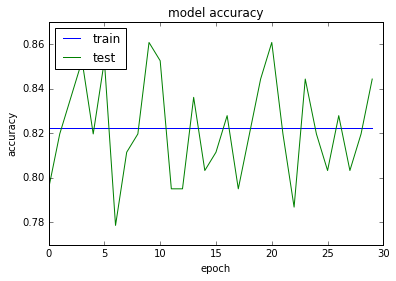

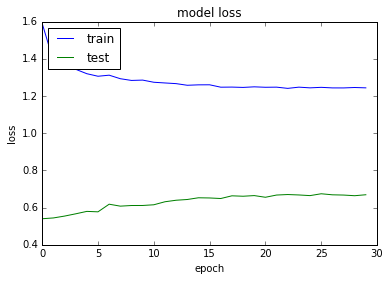

In [85]:
Model_evaluate(model,X_test,y_test,batch_size,history)